In [40]:
import os
# import config as config
from pathlib import Path
import hopsworks
from dotenv import load_dotenv

load_dotenv()
project = hopsworks.login(
    project=os.getenv("HOPSWORKS_PROJECT_NAME"),
    api_key_value=os.getenv("HOPSWORKS_API_KEY")
)
print(os.getenv("HOPSWORKS_PROJECT_NAME"))
print(os.getenv("HOPSWORKS_API_KEY"))
feature_store = project.get_feature_store()
feature_group=feature_store.get_or_create_feature_group(
    name=os.getenv("FEATURE_GROUP_NAME"),
    version=os.getenv("FEATURE_GROUP_VERSION"),
    description= "Time-series Data for Bike at six hour frequency",
    primary_key=["location_id","pickup_hour"],
    event_time="pickup_hour"
)

2025-05-11 12:48:57,229 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-11 12:48:57,233 INFO: Initializing external client
2025-05-11 12:48:57,234 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-11 12:48:58,115 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1228972
citi_bike
xVDMP3X2iA6nyZGr.WK8dropGOARtVcvuSDt5funiBBeKki27I3crjUfpHFRN9EJLbUr9c91KmDUhfnGA


In [5]:
from dotenv import load_dotenv

load_dotenv()
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=os.getenv('FEATURE_VIEW_NAME'),
        version=os.getenv('FEATURE_VIEW_VERSION'),
        query=feature_group.select_all(),
    )
    print(f"Feature view '{os.getenv('FEATURE_VIEW_NAME')}' (version {os.getenv('FEATURE_VIEW_VERSION')}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=os.getenv('FEATURE_VIEW_NAME'),
        version=os.getenv('FEATURE_VIEW_VERSION'),
    )
    print(f"Feature view '{os.getenv('FEATURE_VIEW_NAME')}' (version {os.getenv('FEATURE_VIEW_VERSION')}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1228972/featurestores/1213539/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_six_hourly_feature_view_bike, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_six_hourly_feature_view_bike, version: 1
Feature view 'time_series_six_hourly_feature_view_bike' (version 1) retrieved successfully.


In [6]:
ts_data, _ = feature_view.training_data(
    description="time_series_six_hourly_bike_ride"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.17s) 


In [7]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3974 entries, 0 to 3973
Columns: 119 entries, pickup_hour to is_weekend
dtypes: float64(112), int32(4), int64(1), object(2)
memory usage: 3.5+ MB


In [8]:
ts_data = ts_data.sort_values(["location_id", "pickup_hour"]).reset_index(drop=True)

In [9]:
ts_data.head()

,pickup_hour,location_id,target,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,target_lag_7,...,target_lag_107,target_lag_108,target_lag_109,target_lag_110,target_lag_111,target_lag_112,hour,day_of_week,month,is_weekend
0,2024-01-31 00:00:00+00:00,5329.03,2,50.0,76.0,55.0,3.0,47.0,45.0,51.0,...,1.0,10.0,66.0,13.0,7.0,1.0,0,2,1,0
1,2024-01-31 06:00:00+00:00,5329.03,54,2.0,50.0,76.0,55.0,3.0,47.0,45.0,...,42.0,1.0,10.0,66.0,13.0,7.0,6,2,1,0
2,2024-01-31 12:00:00+00:00,5329.03,72,54.0,2.0,50.0,76.0,55.0,3.0,47.0,...,80.0,42.0,1.0,10.0,66.0,13.0,12,2,1,0
3,2024-01-31 18:00:00+00:00,5329.03,66,72.0,54.0,2.0,50.0,76.0,55.0,3.0,...,54.0,80.0,42.0,1.0,10.0,66.0,18,2,1,0
4,2024-02-01 00:00:00+00:00,5329.03,4,66.0,72.0,54.0,2.0,50.0,76.0,55.0,...,3.0,54.0,80.0,42.0,1.0,10.0,0,3,2,0


In [10]:
ts_data["pickup_hour"].min()

'2024-01-29 00:00:00+00:00'

In [11]:
ts_data["pickup_hour"].max()

'2024-12-31 18:00:00+00:00'

In [12]:
ts_data_copy = ts_data.copy()

In [13]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [14]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3974 entries, 0 to 3973
Columns: 119 entries, pickup_hour to is_weekend
dtypes: datetime64[ns, UTC](1), float64(112), int32(4), int64(1), object(1)
memory usage: 3.5+ MB


In [15]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [16]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3974 entries, 0 to 3973
Columns: 119 entries, pickup_hour to is_weekend
dtypes: datetime64[ns](1), float64(112), int32(4), int64(1), object(1)
memory usage: 3.5+ MB


In [17]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

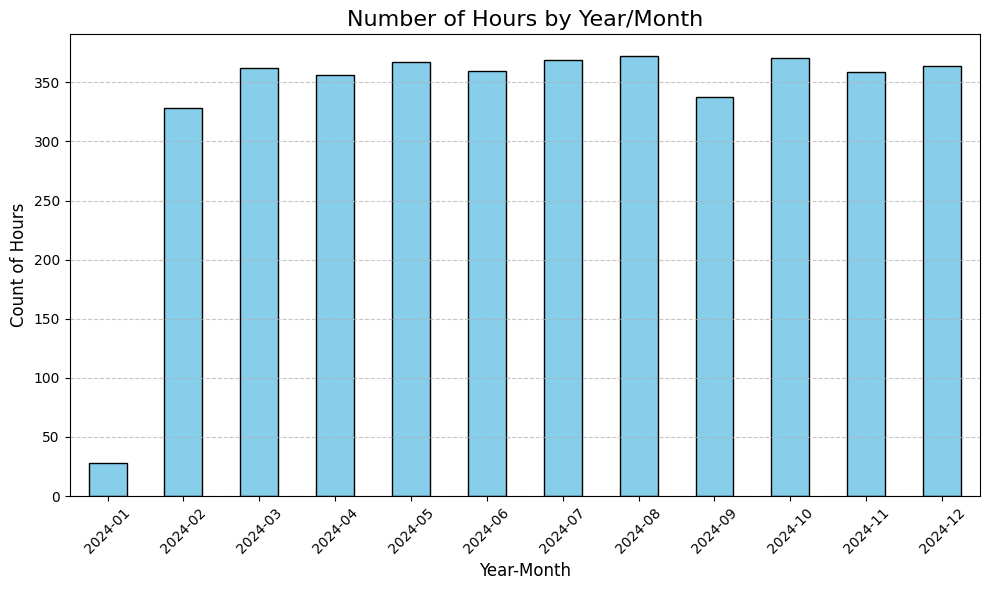

In [18]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [19]:
from datetime import datetime, timedelta  
import pandas as pd  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-04-13 12:03:46.170731')

In [20]:
from typing  import Tuple
def split_time_series_data(
    df: pd.DataFrame,
    cutoff_date: datetime,
    target_column: str,
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a time series DataFrame into training and testing sets based on a cutoff date.

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        cutoff_date (datetime): The date used to split the data into training and testing sets.
        target_column (str): The name of the target column to separate from the features.

    Returns:
        Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
            - X_train (pd.DataFrame): Training features.
            - y_train (pd.Series): Training target values.
            - X_test (pd.DataFrame): Testing features.
            - y_test (pd.Series): Testing target values.
    """
    # Split the data into training and testing sets based on the cutoff date
    train_data = df[df["pickup_hour"] < cutoff_date].reset_index(drop=True)
    test_data = df[df["pickup_hour"] >= cutoff_date].reset_index(drop=True)

    # Separate features (X) and target (y) for both training and testing sets
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]

    return X_train, y_train, X_test, y_test

In [21]:
X_train, y_train, X_test, y_test = split_time_series_data(
    ts_data,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3974, 119)
(3974,)
(0, 119)
(0,)


In [22]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

In [23]:
def train_lgb_regression_model(df):
    features = [col for col in df.columns if col not in ['pickup_hour', 'target', 'location_id']]
    X = df[features]
    y = df['target']

    model = lgb.LGBMRegressor(random_state=42)
    tscv = TimeSeriesSplit(n_splits=5)

    rmse_scores, mae_scores, r2_scores, mape_scores = [], [], [], []

    print("🚀 Training LightGBM regression model...")
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        dashhubmod=model

        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
        mape_scores.append(np.mean(np.abs((y_test - y_pred) / y_test)) * 100)

    print("\n📊 Evaluation Metrics (5-fold CV):")
    print(f"➡️  Mean Absolute Error (MAE): {np.mean(mae_scores):.2f}")
    print(f"➡️  Mean Absolute Percentage Error (MAPE): {np.mean(mape_scores):.2f}%")
    print(f"➡️  Root Mean Squared Error (RMSE): {np.mean(rmse_scores):.2f}")
    print(f"➡️  R-squared (R²): {np.mean(r2_scores):.2f}")

    return model, features,X_test,rmse_scores,mae_scores,r2_scores,mape_scores

In [24]:
print("📈 Training regression model...")
ts_data, _ = feature_view.training_data(
    description="time_series_six_hourly_bike_ride"
)
df_transformed=pd.read_parquet("transformeddata2024.parquet")
reg_model, reg_features,X_test,rmse_scores,mae_scores,r2_scores,mape_scores = train_lgb_regression_model(ts_data)
    
print("📌 Calculating feature importance...")
feature_importance = pd.DataFrame({
    'feature': reg_features,
    'importance': reg_model.feature_importances_
    }).sort_values(by='importance', ascending=False)

print("\n🏆 Top 5 Important Features:")
print(feature_importance.head())

📈 Training regression model...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.07s) 
2025-05-11 12:03:51,889 INFO: Provenance cached data - overwriting last accessed/created training dataset from 2 to 3.


🚀 Training LightGBM regression model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16749
[LightGBM] [Info] Number of data points in the train set: 664, number of used features: 116
[LightGBM] [Info] Start training from score 108.406627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [25]:
class LightGBMRegressorModel:
    """
    A wrapper around LightGBM Regressor for consistent interface.
    """

    def __init__(self, **kwargs):
        self.model = lgb.LGBMRegressor(random_state=42, **kwargs)

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        self.model.fit(X_train, y_train)

    def predict(self, X_test: pd.DataFrame) -> np.ndarray:
        return self.model.predict(X_test)

    def feature_importance(self, feature_names: list) -> pd.DataFrame:
        return pd.DataFrame({
            "feature": feature_names,
            "importance": self.model.feature_importances_
        }).sort_values(by="importance", ascending=False)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load transformed data
df, _ = feature_view.training_data(
    description="time_series_six_hourly_bike_ride"
)

# Define features and target
features = [col for col in df.columns if col not in [ 'target','pickup_hour']]
# Remove decimal point and convert to int, in-place
df["location_id"] = df["location_id"].astype(str).str.replace(".", "", regex=False).astype(int)

X = df[features]
y = df['target']

# Train/test split
split_idx = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Train LightGBM model
lgb_model = LightGBMRegressorModel()
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("📊 LightGBM Model Evaluation:")
print(f"➡️ MAE:  {mae:.2f}")
print(f"➡️ MAPE: {mape:.2f}%")
print(f"➡️ RMSE: {rmse:.2f}")
print(f"➡️ R²:   {r2:.2f}")

# Feature importance
print("\n🏆 Top 5 Feature Importances:")
print(lgb_model.feature_importance(features).head())


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 
2025-05-11 12:04:02,186 INFO: Provenance cached data - overwriting last accessed/created training dataset from 3 to 4.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28582
[LightGBM] [Info] Number of data points in the train set: 3179, number of used features: 117
[LightGBM] [Info] Start training from score 107.116703
📊 LightGBM Model Evaluation:
➡️ MAE:  21.67
➡️ MAPE: 64.39%
➡️ RMSE: 34.04
➡️ R²:   0.83

🏆 Top 5 Feature Importances:
          feature  importance
1    target_lag_1         189
4    target_lag_4         133
114   day_of_week          87
2    target_lag_2          67
3    target_lag_3          63


In [26]:
import joblib
joblib.dump(lgb_model.model, "lightgbm_bikeride_model.joblib")

['lightgbm_bikeride_model.joblib']

In [27]:
ts_data

,pickup_hour,location_id,target,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,target_lag_7,...,target_lag_107,target_lag_108,target_lag_109,target_lag_110,target_lag_111,target_lag_112,hour,day_of_week,month,is_weekend
0,2024-04-13 06:00:00+00:00,5329.03,61,9.0,124.0,118.0,76.0,2.0,55.0,94.0,...,4.0,131.0,182.0,67.0,1.0,185.0,6,5,4,1
1,2024-08-12 00:00:00+00:00,5329.03,9,115.0,272.0,89.0,3.0,102.0,273.0,115.0,...,109.0,13.0,238.0,117.0,85.0,7.0,0,0,8,0
2,2024-10-13 00:00:00+00:00,5329.03,12,151.0,367.0,97.0,3.0,155.0,256.0,126.0,...,14.0,149.0,372.0,157.0,11.0,220.0,0,6,10,1
3,2024-08-02 12:00:00+00:00,5329.03,193,117.0,6.0,261.0,182.0,133.0,12.0,277.0,...,196.0,66.0,10.0,106.0,169.0,69.0,12,4,8,0
4,2024-07-27 12:00:00+00:00,5905.14,249,99.0,31.0,141.0,211.0,134.0,25.0,172.0,...,129.0,198.0,83.0,38.0,181.0,359.0,12,5,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,2024-09-18 06:00:00+00:00,5329.03,120,5.0,257.0,218.0,148.0,8.0,234.0,230.0,...,212.0,114.0,7.0,236.0,193.0,106.0,6,2,9,0
3970,2024-08-22 18:00:00+00:00,5329.03,248,212.0,114.0,7.0,236.0,193.0,106.0,8.0,...,14.0,205.0,265.0,122.0,8.0,266.0,18,3,8,0
3971,2024-12-13 06:00:00+00:00,5329.03,55,2.0,49.0,38.0,94.0,2.0,25.0,47.0,...,1.0,89.0,214.0,107.0,1.0,84.0,6,4,12,0
3972,2024-08-13 18:00:00+00:00,5329.03,312,195.0,141.0,7.0,261.0,174.0,119.0,9.0,...,10.0,204.0,131.0,122.0,10.0,258.0,18,1,8,0


In [28]:
from datetime import datetime, timedelta

# Convert pickup_hour to datetime if it's a string
last_row = df.iloc[-1].copy()
if isinstance(last_row['pickup_hour'], str):
    last_row['pickup_hour'] = pd.to_datetime(last_row['pickup_hour'])

# Now safely add one hour
next_hour_time = last_row['pickup_hour'] + timedelta(hours=1)

# Prepare the input row
new_data = {}

# Shift lag features (assumes lag_2 becomes lag_1, lag_3 becomes lag_2, etc.)
for lag in range(1, 28):
    new_data[f"target_lag_{lag}"] = last_row.get(f"target_lag_{lag + 1}", 0)

# The last known target becomes target_lag_28
new_data["target_lag_28"] = last_row["target"]

# Add temporal features
new_data["hour"] = next_hour_time.hour
new_data["day_of_week"] = next_hour_time.dayofweek

# Copy over any remaining static features
for col in features:
    if col not in new_data and col in last_row:
        new_data[col] = last_row[col]

# Create DataFrame
X_next = pd.DataFrame([new_data])[features]

# Predict
next_hour_prediction = lgb_model.predict(X_next)[0]
print(f"📈 Predicted ride count for next hour ({next_hour_time}): {next_hour_prediction:.2f}")


📈 Predicted ride count for next hour (2024-02-12 19:00:00+00:00): 62.96


In [29]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [32]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="Bike_demand_predictor_next_hour",
    metrics={"test_mae": mae},
    description="LightGBM regressor",
    input_example=X_train.sample(),
    model_schema=model_schema)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save('../models')

Uploading c:\Users\Jaath\github\Citi Bike Trip Prediction System\Back-end\../models/lightgbm_bikeride_model.joblib: 100.000%|██████████| 279868/279868 elapsed<00:02 remaining<00:00
Uploading c:\Users\Jaath\github\Citi Bike Trip Prediction System\Back-end\input_example.json: 100.000%|██████████| 761/761 elapsed<00:01 remaining<00:00
Uploading c:\Users\Jaath\github\Citi Bike Trip Prediction System\Back-end\model_schema.json: 100.000%|██████████| 9523/9523 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.93s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1228972/models/Bike_demand_predictor_next_hour/1


Model(name: 'Bike_demand_predictor_next_hour', version: 1)

In [33]:
import joblib
def get_hopsworks_project() -> hopsworks.project.Project:
    return hopsworks.login(
        project=os.getenv('HOPSWORKS_PROJECT_NAME'), api_key_value=os.getenv('HOPSWORKS_API_KEY')
    )
project = get_hopsworks_project()
model_registry = project.get_model_registry()

models = model_registry.get_models(name='Bike_demand_predictor_next_hour')
model = max(models, key=lambda model: model.version)
model_dir = model.download()
model = joblib.load(Path(model_dir) / "lightgbm_bikeride_model.joblib")

2025-05-11 12:04:46,035 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-11 12:04:46,038 INFO: Initializing external client
2025-05-11 12:04:46,040 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-11 12:04:47,058 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1228972


Downloading: 100.000%|██████████| 279868/279868 elapsed<00:00 remaining<00:00

In [34]:
model.get_metadata_routing

<bound method _MetadataRequester.get_metadata_routing of LGBMRegressor(random_state=42)>

In [35]:
X_train

,location_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,target_lag_7,target_lag_8,target_lag_9,...,target_lag_107,target_lag_108,target_lag_109,target_lag_110,target_lag_111,target_lag_112,hour,day_of_week,month,is_weekend
0,532903,9.0,124.0,118.0,76.0,2.0,55.0,94.0,57.0,2.0,...,4.0,131.0,182.0,67.0,1.0,185.0,6,5,4,1
1,532903,115.0,272.0,89.0,3.0,102.0,273.0,115.0,8.0,58.0,...,109.0,13.0,238.0,117.0,85.0,7.0,0,0,8,0
2,532903,151.0,367.0,97.0,3.0,155.0,256.0,126.0,3.0,133.0,...,14.0,149.0,372.0,157.0,11.0,220.0,0,6,10,1
3,532903,117.0,6.0,261.0,182.0,133.0,12.0,277.0,166.0,133.0,...,196.0,66.0,10.0,106.0,169.0,69.0,12,4,8,0
4,590514,99.0,31.0,141.0,211.0,134.0,25.0,172.0,178.0,119.0,...,129.0,198.0,83.0,38.0,181.0,359.0,12,5,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3174,590514,11.0,153.0,196.0,133.0,11.0,173.0,219.0,138.0,16.0,...,192.0,64.0,22.0,86.0,187.0,62.0,6,4,8,0
3175,614005,268.0,173.0,6.0,182.0,260.0,138.0,10.0,46.0,71.0,...,6.0,178.0,250.0,159.0,6.0,169.0,18,1,5,0
3176,590514,95.0,17.0,153.0,270.0,57.0,33.0,200.0,275.0,138.0,...,288.0,146.0,8.0,199.0,239.0,146.0,12,0,10,0
3177,532903,216.0,70.0,8.0,79.0,132.0,67.0,1.0,73.0,104.0,...,56.0,1.0,54.0,97.0,60.0,1.0,18,5,2,1


In [36]:
def get_model_predictions(model, features: pd.DataFrame) -> pd.DataFrame:
    # past_rides_columns = [c for c in features.columns if c.startswith('rides_')]
    predictions = model.predict(features)

    results = pd.DataFrame()
    results["location_id"] = features["location_id"].values
    results["predicted_demand"] = predictions.round(0)

    return results
preds = get_model_predictions(model, X_train)

In [37]:
features

['location_id',
 'target_lag_1',
 'target_lag_2',
 'target_lag_3',
 'target_lag_4',
 'target_lag_5',
 'target_lag_6',
 'target_lag_7',
 'target_lag_8',
 'target_lag_9',
 'target_lag_10',
 'target_lag_11',
 'target_lag_12',
 'target_lag_13',
 'target_lag_14',
 'target_lag_15',
 'target_lag_16',
 'target_lag_17',
 'target_lag_18',
 'target_lag_19',
 'target_lag_20',
 'target_lag_21',
 'target_lag_22',
 'target_lag_23',
 'target_lag_24',
 'target_lag_25',
 'target_lag_26',
 'target_lag_27',
 'target_lag_28',
 'target_lag_29',
 'target_lag_30',
 'target_lag_31',
 'target_lag_32',
 'target_lag_33',
 'target_lag_34',
 'target_lag_35',
 'target_lag_36',
 'target_lag_37',
 'target_lag_38',
 'target_lag_39',
 'target_lag_40',
 'target_lag_41',
 'target_lag_42',
 'target_lag_43',
 'target_lag_44',
 'target_lag_45',
 'target_lag_46',
 'target_lag_47',
 'target_lag_48',
 'target_lag_49',
 'target_lag_50',
 'target_lag_51',
 'target_lag_52',
 'target_lag_53',
 'target_lag_54',
 'target_lag_55',
 't

In [38]:
preds

,location_id,predicted_demand
0,532903,63.0
1,532903,8.0
2,532903,9.0
3,532903,206.0
4,590514,235.0
...,...,...
3174,590514,120.0
3175,614005,167.0
3176,590514,254.0
3177,532903,73.0
